# Building a Job Posting Classifier!

Going through an entire job application just to find out that it wasn't real is painful! However, it seems like a difficult task to determine if a job posting is fake or not just by the text in it. 

But is it?

Here, we will explore using NLP analysis to gain insight into the legitimacy of job postings.

## We'll start with some preprocessing:

In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup  
import tensorflow
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt
import re
import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download("punkt")
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import auc, confusion_matrix, accuracy_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve
import xgboost as xgb

In [3]:
file = pd.read_csv("fake_job_postings.csv")
file = file.sample(frac = 1).reset_index(drop = True)   #this shuffles the rows around!

In [6]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

It looks like quite a few columns have missing values. Let's see some examples.

In [7]:
file.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,15057,Help Desk Engineer,"US, DC, Washington",NaN,NaN,NaN,Job Description Responsibilities: • Team up wi...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0
1,12104,Product Manager,"GB, , Madrid, Spain | London",Product Development,NaN,Glownet is the UK startup that is revolutioniz...,"SummaryAre you a meticulous end user advocate,...",Fluent written and spoken English is a mustFlu...,We are open to considering candidates enrolled...,0,1,1,NaN,Associate,NaN,Computer Software,Product Management,0
2,10829,Estimating Admin,"US, TX, Fort Worth",Estimating,NaN,"Founded in 1974 in Canada, and in 1985 in the ...",The Estimating Admin will perform administrati...,"To perform this job successfully, an individua...","Base, Bonus, Retirement, Time Off, Medical, De...",0,1,1,Full-time,Associate,High School or equivalent,Construction,Administrative,0


#### Some of these columns are useless for determining whether the job is fake or not, so let's drop them.

In [8]:
for col in ["job_id", "salary_range", "telecommuting", "has_company_logo", "has_questions", "employment_type"]:
    file.drop(col, inplace = True, axis = 1)    

#### Let's also fill in the Location and Department positions with the most common value

In [9]:
for job in ["location", "department"]:
    file[job] = file[job].fillna(file[job].value_counts().index[0])

In [10]:
frauds = file[file["fraudulent"] == 1]
non_frauds = file[file["fraudulent"] == 0]
print(len(non_frauds))

17014


## We will clean and preprocess the data to prepare it for our models.

### Data Cleaning with BeautifulSoup


In [17]:
stops = set(stopwords.words("english")) 

#1: Beautify the raw text (remove oddities, formatting, JSON, etc.)
#2: Remove non-letters
#3: Make everything lowercase 
#4: Remove stopwords (basic, non-informational words)

def text_to_words(raw_text):
    beautified = BeautifulSoup(raw_text).get_text()
    letters_only = re.sub("[^a-zA-Z]", " ", beautified)
    words = letters_only.lower().split()
    useful_words = [w for w in words if not w in stops]
    return(" ".join(useful_words))   

In [18]:
clean_file = pd.DataFrame()
for col in ["title", "location", "department", "company_profile", "description", "requirements", "benefits", "required_experience", "required_education", "industry", "function"]:
    file[col]=file[col].apply(str)
    clean_file["clean_{}".format(col)] = file[col].apply(text_to_words)

C:\Users\aymed\AppData\Local\Temp\ipykernel_81064\3992957516.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  beautified = BeautifulSoup(raw_text).get_text()
C:\Users\aymed\AppData\Local\Temp\ipykernel_81064\3992957516.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  beautified = BeautifulSoup(raw_text).get_text()
C:\Users\aymed\AppData\Local\Temp\ipykernel_81064\3992957516.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  beautified = BeautifulSoup(raw_text).get_text()
C:\Users\aymed\AppData\Local\Temp\ipykernel_81064\3992957516.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file

In [19]:
clean_file.head(1)

,clean_title,clean_location,clean_department,clean_company_profile,clean_description,clean_requirements,clean_benefits,clean_required_experience,clean_required_education,clean_industry,clean_function
0,help desk engineer,us dc washington,sales,nan,job description responsibilities team groups u...,nan,nan,nan,nan,nan,nan


#### We will take our cleaned text and turn it all into a single string for processing.

In [21]:
all_clean = clean_file.iloc[:,0]+" "+clean_file.iloc[:,1]+" "+clean_file.iloc[:,2]+" "+clean_file.iloc[:,3]+\
            " "+clean_file.iloc[:,4]+" "+clean_file.iloc[:,5]+" "+clean_file.iloc[:,6]+" "+clean_file.iloc[:,7]+\
            " "+clean_file.iloc[:,8]+" "+clean_file.iloc[:,9]+" "+clean_file.iloc[:,10]
all_clean[:5]

0    help desk engineer us dc washington sales nan ...
1    product manager gb madrid spain london product...
2    estimating admin us tx fort worth estimating f...
3    digital marketing activator gb london sales te...
4    project controls tech us co denver oil energy ...
dtype: object

#### Now, we will use a Lemmatizer to group the words.

In [22]:
# Lemmatizing turns all variants of a word into the same word.
# i.e. 'run', 'running', and 'ran' would all become run.

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

complete_clean = all_clean.apply(lemmatize_text)
complete_clean = pd.Series([' '.join(map(str, l)) for l in complete_clean])

In [23]:
complete_clean[:5]

0    help desk engineer u dc washington sale nan jo...
1    product manager gb madrid spain london product...
2    estimating admin u tx fort worth estimating fo...
3    digital marketing activator gb london sale tec...
4    project control tech u co denver oil energy st...
dtype: object

## We will first try to use Bag of Words (BoW) to classify the jobs!

### Creating the Training and Testing Set

In [25]:
from sklearn.model_selection import train_test_split as tts
X_train,X_test,y_train,y_test = tts(complete_clean,file["fraudulent"], random_state = 9669, test_size = 0.2, shuffle=True, stratify = file["fraudulent"])

In [26]:
X_train.shape,y_train.value_counts(normalize=True),y_test.value_counts(normalize=True)

((14304,),
 fraudulent
 0    0.951552
 1    0.048448
 Name: proportion, dtype: float64,
 fraudulent
 0    0.951622
 1    0.048378
 Name: proportion, dtype: float64)

### Bag of Words

In [27]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, 
                             stop_words = None, max_features = 5000, ngram_range=(1,3)) 
vector = vectorizer.fit(list(X_train))

In [28]:
train_features = vectorizer.transform(list(X_train)).toarray()
test_features = vectorizer.transform(list(X_test)).toarray()

In [29]:
df_features = pd.DataFrame(train_features)
test_df = pd.DataFrame(test_features)

In [31]:
#This is the output file: Each column represents a word, and each row is a job.
df_features

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14299,0,0,0,0,0,0,0,0,0,0,...,2,1,0,0,0,0,0,0,0,0
14300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14302,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Trying out a few different ML models (RF, LR, SVM, XGB, NN)

In [67]:
def test(type, df_features,y_train,y_test):
    
    fig, (ax1,ax2) = plt.subplots(nrows=2,figsize=(7,11))
    if type == "Random Forest":
        model = RandomForestClassifier(n_estimators = 100, random_state = 7643, verbose = False, n_jobs = -1) 
    elif type == "Logistic Regression":
        model = LogisticRegression(random_state = 7643, verbose = False, n_jobs = -1) 
    # elif type == "SVM":
    #     model = svm.LinearSVC(verbose = 1, C = 1.0)
    elif type == "XGBoost":
        model = xgb.XGBClassifier(n_estimators=100, objective='binary:logistic', verbose = False, n_jobs = -1)
    elif type == "NN":
        model = Sequential()
        model.add(Dense(units = 100, activation = 'relu' , input_dim = df_features.shape[1]))
        model.add(Dropout(0.5))
        model.add(Dense(units = 1 , activation = 'sigmoid'))
        model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['Precision','Recall'])
        model.summary()
        
    if type == "NN":
        model.fit(df_features,y_train, batch_size = 32, epochs = 10)
        y_pred_proba = model.predict(test_df)
        y_pred = [np.rint(y) for y in y_pred_proba]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test,y_pred_proba)
    else:
        model.fit(df_features,y_train)
        y_pred_proba = model.predict_proba(test_df)
        y_pred = model.predict(test_df)
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:,1])
        roc_auc = roc_auc_score(y_test,y_pred_proba[:,1])
        
    conf = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(conf)
    disp.plot(ax = ax1)
    ax1.set_title("Confusion Matrix")
    [[tn,fp],
     [fn,tp]] = conf

    print(type+": ")
    print("Accuracy: {:.3f}".format((tp+tn)/(tp+tn+fp+fn)))
    print("Precision: {:.3f}".format((tp)/(tp+fp)))
    print("Recall: {:.3f}".format((tp)/(tp+fn)))
    print("F1: {:.3f}".format((2*((tp)/(tp+fp))*((tp)/(tp+fn)))/(((tp)/(tp+fp))+((tp)/(tp+fn)))))

    print("AUPRC: {}".format(auc(recall, precision)))
    print("AUC: {}".format(roc_auc))

    ax2.set_title("Precision-Recall Curve")
    ax2.plot(recall, precision, marker='.', label=type)
    ax2.set(xlabel='Recall',ylabel = 'Precision')
    plt.show()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               500100    
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 101       
                                                                 
Total params: 500,201
Trainable params: 500,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
447/447 [==============================] - 6s 12ms/step - loss: 0.1040 - precision: 0.8263 - recall: 0.3983
Epoch 2/10
447/447 [==============================] - 5s 11ms/step - loss: 0.0438 - precision: 0.9344 - recall: 0.7605
Epoch 3/10
447/447 [==============================] - 4s 9ms/step - loss: 

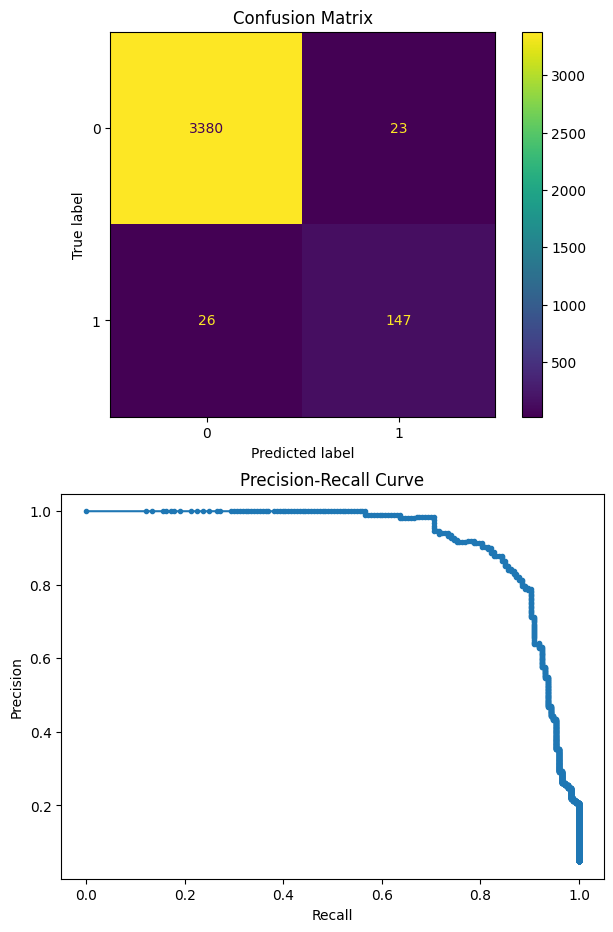

In [47]:
test("NN",df_features,y_train,y_test)

## As we can see from the above, the neural network is very good at classifying job posts, with an F1 Score of 0.86 and AUPRC of 0.92 even with a relatively small model.

Random Forest: 
Accuracy: 0.980
Precision: 1.000
Recall: 0.584
F1: 0.737
AUPRC: 0.9180366750558338
AUC: 0.9871517651035553


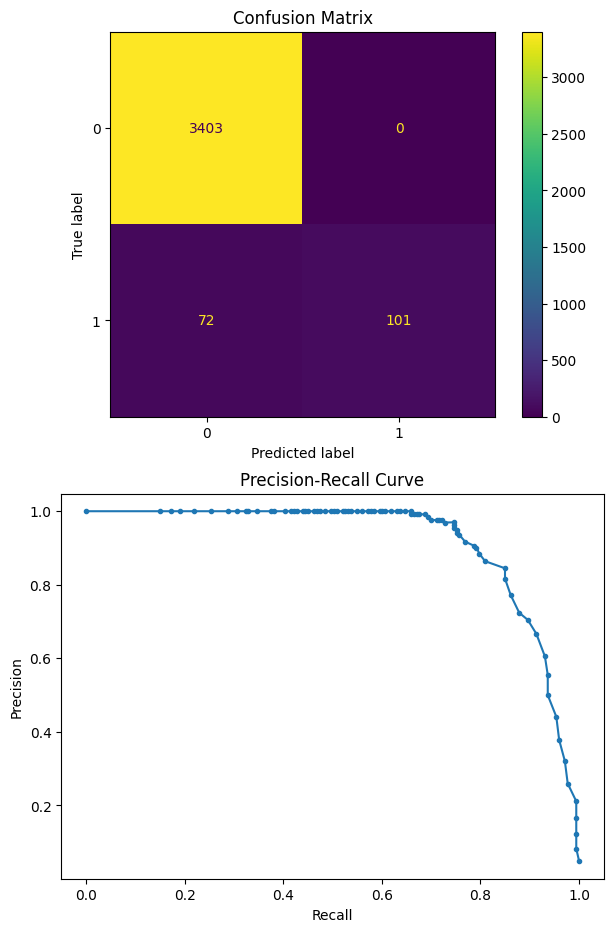

Logistic Regression: 
Accuracy: 0.980
Precision: 0.810
Recall: 0.763
F1: 0.786
AUPRC: 0.8678616243164896
AUC: 0.9787131042144045


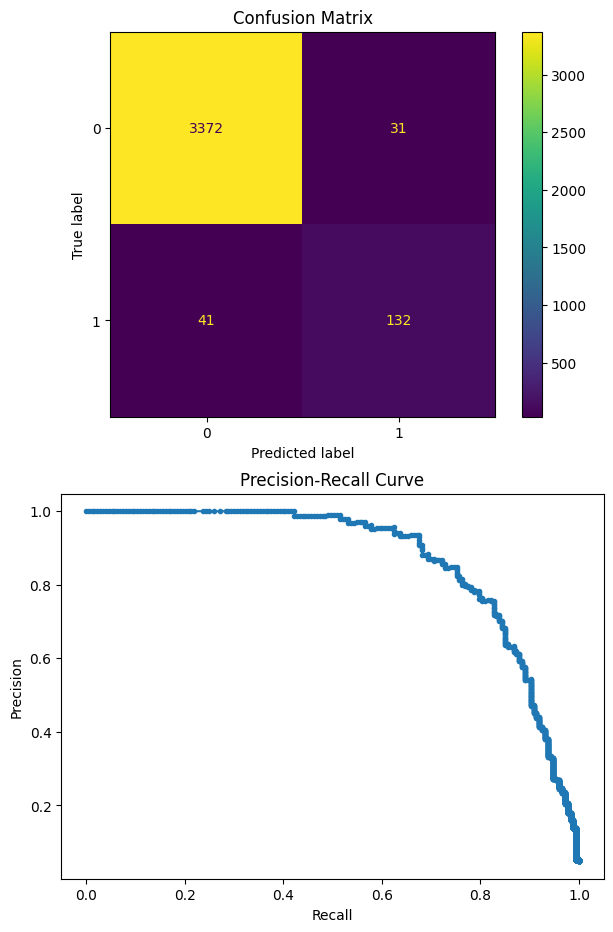

[14:49:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

XGBoost: 
Accuracy: 0.984
Precision: 0.939
Recall: 0.711
F1: 0.809
AUPRC: 0.9217820971351423
AUC: 0.9845546007518018


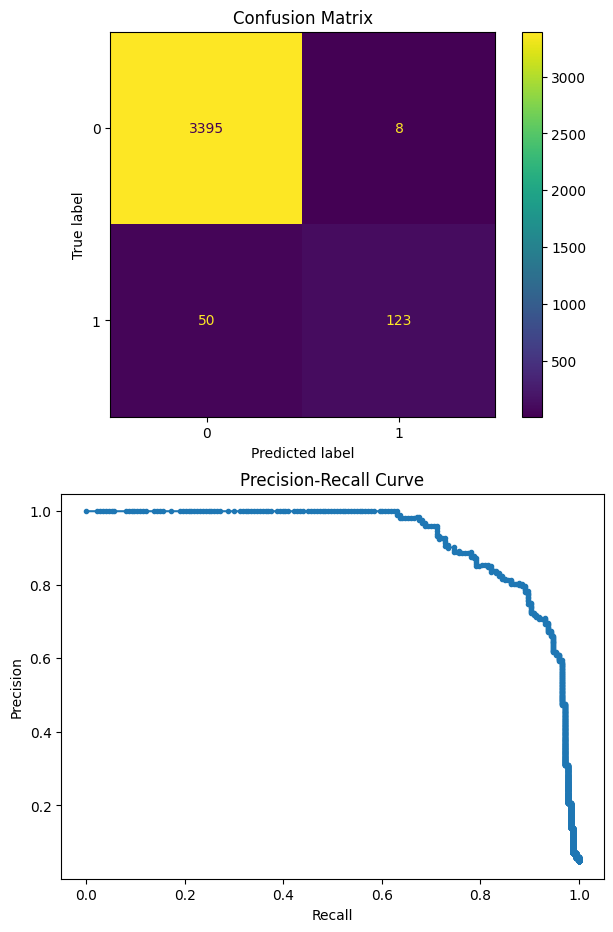

In [68]:
test("Random Forest",df_features,y_train,y_test)
test("Logistic Regression",df_features,y_train,y_test)
test("XGBoost",df_features,y_train,y_test)

## The above 3 are not as great:
### Random Forest seems to be too conservative an might require sub-samples/bootstrapping
### XGBoost accounts for some of the flaws of RF, but still fails to beat Logistic Regression
### Logistic Regression does decently, but the NN still outperforms it

# That does it! Thank you for exploring my analysis of fake vs real job posts!